![text](header_workflow.png)

### MLP-based model compression 

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2026-01-13 20:18:06.575437: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 20:18:06.621658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 20:18:07.310619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  0


2026-01-13 20:18:08.258441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2026-01-13 20:18:08.258489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mareKaleido
2026-01-13 20:18:08.258495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mareKaleido
2026-01-13 20:18:08.258675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2026-01-13 20:18:08.258697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2026-01-13 20:18:08.258702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


#### Load dataset

In [3]:
# Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0          


#### Fashion MNIST: classes

| Label | Class |  
|-----------|-----------|
|0  | T-shirt/top	   |
|1	|Trouser    |
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag	|
|9	|Ankle boot|

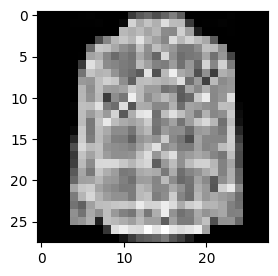

In [4]:
# Image index

N = 32

plt.figure(figsize=(3,3))
plt.imshow(x_train[N], cmap='gray')

In [5]:
# Labels
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Load model



In [6]:
model = load_model('fashionMNIST.h5')

2026-01-13 20:18:10.685870: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xba09cf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-13 20:18:10.685913: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version


In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
Total params: 219,818
Trainable params: 219,818
Non-tr

In [8]:
n_classes = 10
# One-hot encode labels
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Pruning

In [10]:
import math
epochs = 64
batch = 64
lr = 0.0001
op = Adam(lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
val_split = 0.2

final_sparsity = 0.2



N = x_train.shape[0]
N_train = int((1 - val_split) * N)
steps_per_epoch = math.ceil(N_train / batch)
end_step = steps_per_epoch * epochs

## PolynomialDecay: gradually increases the sparsity of a model over time using a polynomial function. 
# This helps in iterative pruning, where pruning is applied progressively rather than all at once, 
# improving accuracy retention.

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=end_step
                )
            }

In [11]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

### Model training

In [12]:
history = modelP.fit(
                x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
            )

Epoch 1/64
750/750 [==============================] - 4s 3ms/step - loss: 0.4633 - accuracy: 0.8379 - val_loss: 0.4214 - val_accuracy: 0.8512
Epoch 2/64
750/750 [==============================] - 2s 3ms/step - loss: 0.4239 - accuracy: 0.8508 - val_loss: 0.4004 - val_accuracy: 0.8565
Epoch 3/64
750/750 [==============================] - 2s 3ms/step - loss: 0.3946 - accuracy: 0.8580 - val_loss: 0.3922 - val_accuracy: 0.8573
Epoch 4/64
750/750 [==============================] - 2s 3ms/step - loss: 0.3741 - accuracy: 0.8655 - val_loss: 0.3722 - val_accuracy: 0.8656
Epoch 5/64
750/750 [==============================] - 2s 3ms/step - loss: 0.3576 - accuracy: 0.8719 - val_loss: 0.3546 - val_accuracy: 0.8735
Epoch 6/64
750/750 [==============================] - 2s 3ms/step - loss: 0.3473 - accuracy: 0.8754 - val_loss: 0.3572 - val_accuracy: 0.8713
Epoch 7/64
750/750 [==============================] - 2s 3ms/step - loss: 0.3326 - accuracy: 0.8813 - val_loss: 0.3486 - val_accuracy: 0.8762
Epoch 

In [13]:
# Model evaluation
test_loss, test_acc = modelP.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 [==============================] - 0s 1ms/step - loss: 0.3503 - accuracy: 0.8900

Test accuracy: 0.8900


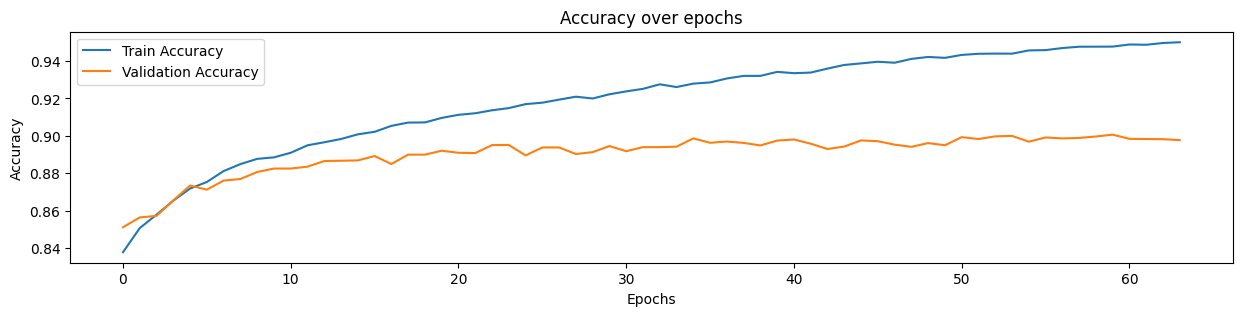

In [14]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

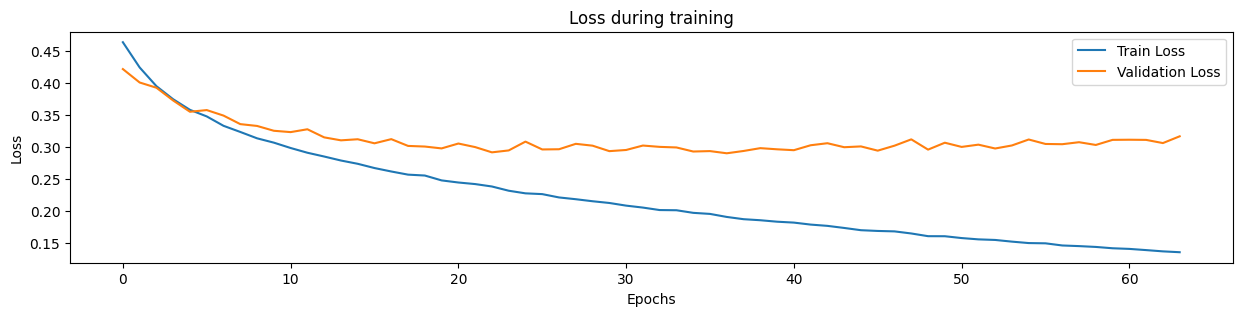

In [15]:
# Plot accuracy over loss
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Confusion Matrix

313/313 [==============================] - 0s 542us/step


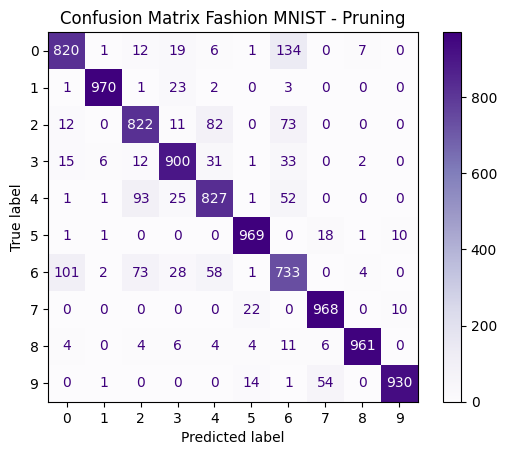

In [17]:
y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix Fashion MNIST - Pruning')
plt.show()


### Quantization-aware training

QDense: A quantized version of Dense.

quantized_bits(N, M, alpha):

- N: Total bits used.

- M: Bits for the fractional part.

- alpha: Scaling factor.

QActivation: Applies quantized activations such as quantized_relu and quantized_softmax.

In [18]:

kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8, 4,alpha=1)"
activationQ = 'quantized_bits(8, 4)'

modelQAT = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(250, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(100, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

/tools/anaconda3/envs/neuralEnv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [19]:
modelQAT.summary()

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc1 (QDense)                (None, 250)               196250    
                                                                 
 relu1 (QActivation)         (None, 250)               0         
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 fc2 (QDense)                (None, 100)               25100     
                                                                 
 relu2 (QActivation)         (None, 100)               0         
                                                                 
 dropout_1 (Dropout)         (None, 100)            

In [20]:
# Training (QAT)

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
H = modelQAT.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )


Epoch 1/16
750/750 [==============================] - 3s 3ms/step - loss: 1.3016 - accuracy: 0.7165 - val_loss: 0.6874 - val_accuracy: 0.7860
Epoch 2/16
750/750 [==============================] - 2s 2ms/step - loss: 0.7402 - accuracy: 0.7677 - val_loss: 0.6315 - val_accuracy: 0.7895
Epoch 3/16
750/750 [==============================] - 2s 2ms/step - loss: 0.6759 - accuracy: 0.7813 - val_loss: 0.6034 - val_accuracy: 0.8016
Epoch 4/16
750/750 [==============================] - 2s 2ms/step - loss: 0.6334 - accuracy: 0.7910 - val_loss: 0.5512 - val_accuracy: 0.8121
Epoch 5/16
750/750 [==============================] - 2s 2ms/step - loss: 0.6179 - accuracy: 0.7937 - val_loss: 0.6595 - val_accuracy: 0.7868
Epoch 6/16
750/750 [==============================] - 2s 3ms/step - loss: 0.6150 - accuracy: 0.7938 - val_loss: 0.5602 - val_accuracy: 0.8121
Epoch 7/16
750/750 [==============================] - 2s 3ms/step - loss: 0.6074 - accuracy: 0.7993 - val_loss: 0.5626 - val_accuracy: 0.8072
Epoch 

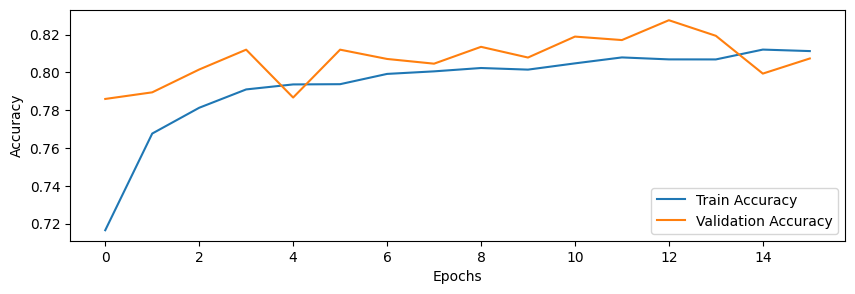

In [21]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 1ms/step


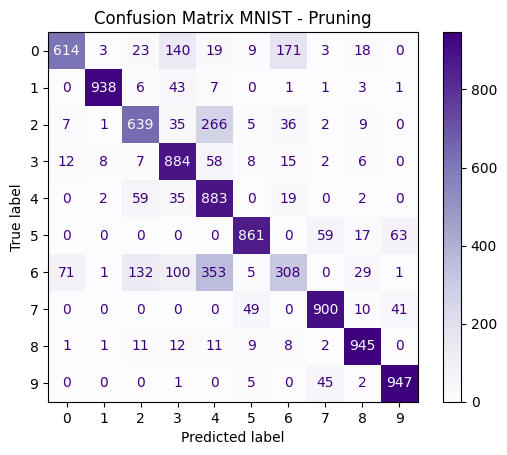

In [22]:
y_pred_probs = modelQAT.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')
plt.show()


---
Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy